# Project Solution Lab 2: 

# 问题：预测航班延误

本笔记本的多个目标为：
- 处理下载的 ZIP 文件并利用其创建数据集
- 执行探索性数据分析 (EDA)
- 建立基准模型
- 将简单模型转化为集成模型
- 进行超参数优化
- 确认特征重要性

## 业务场景简介
您在一家行程预订网站工作，该网站致力于改善航班延误的旅客的客户体验。该公司希望开发一种功能，让美国的乘客在预订国内最繁忙机场的到港或离港航班时，能够知道航班是否会因天气原因而延误。

您的任务是利用机器学习来确定航班是否会因天气原因而延误，从而在一定程度上解决这一问题。您可以访问大型航空公司国内航班的准点率数据集。您可以使用这一数据来训练机器学习模型，以便预测最繁忙机场的航班是否会延误。

## 关于该数据集
该数据集包含经过认证的美国航空公司报告的预定和实际的出发与到达时间。对于预定行程的国内旅客产生的收入，这些航空公司至少占据了 1%。数据由美国交通统计局 (BTS) 下属的航空公司信息办公室收集。数据集包含 2013 到 2018 年间航班的日期、时刻、出发地、目的地、航空公司、航程以及航班延误状态。

### 特征
有关数据集内的特征的更多信息，请参阅 [准点延误数据集特征](https://www.transtats.bts.gov/Fields.asp)。

### 数据集属性  
网站：https://www.transtats.bts.gov/

本实验使用的数据集由美国交通统计局 (BTS) 下属的航空公司信息办公室编制，取自航空公司准点率数据库，网站为 https://www.transtats.bts.gov/DatabaseInfo.asp?DB_ID=120&amp;DB_URL=Mode_ID=1&amp;Mode_Desc=Aviation&amp;Subject_ID2=0。

# 步骤 1：问题定义和数据收集

在开始这个项目时，先在下面用几句话来总结在这个场景中要解决的业务问题和要实现的业务目标。同时说明您想让自己的团队衡量的业务指标。确定这些信息后，请清楚地写出机器学习问题陈述。最后，添加一两条备注，说明问题陈述所对应的机器学习的类型。

#### <span style="color: blue;">项目演示：在项目演示中总结这些详细信息。</span>


### 1.确定 ML 是否是适合部署的解决方案以及原因。
\# 在此处写出答案

### 2.定义业务问题、成功指标和期望的 ML 输出。
\# 在此处写出答案

### 3.确定您要解决的 ML 问题的类型。
\# 在此处写出答案

### 4.分析您要使用的数据是否合适。
\# 在此处写出答案

### 设置

我们已经确定了工作重点，现在我们来进行一些设置，以便开始解决问题。

**注意：**该笔记本是在 `ml.m4.xlarge` 笔记本实例上创建和测试的。

In [1]:
import os
from pathlib2 import Path
from zipfile import ZipFile
import time

import pandas as pd
import numpy as np
import subprocess

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# 步骤 2：数据预处理和可视化
在数据预处理阶段，您应该利用机会探索数据并将其可视化，以便更好地了解数据。首先，导入必要的库并将数据读入 Pandas dataframe。然后，探索数据。查看数据集的形状，探索要使用的列及其类型（数值型、分类型）。对各项特征执行基本统计，以便了解特征的均值和范围；深入分析目标列并确定其分布。

### 要考虑的具体问题
1.您可以从对特征执行的基本统计中推断出什么？ 

2.您可以从目标类的分布中推断出什么？

3.您从数据探索中还推断出了什么？

#### <span style="color: blue;">项目演示：在项目演示中总结这些问题和其他类似问题的答案。</span>

首先将 Amazon S3 公有存储桶中的数据集引入这个笔记本环境。

In [2]:
# 检查文件是否已位于所需路径中，或者是否需要下载

base_path = '/home/ec2-user/SageMaker/project/data/FlightDelays/'
csv_base_path = '/home/ec2-user/SageMaker/project/data/csvFlightDelays/'
file_path = 'On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_1.zip'

if not os.path.isfile(base_path + file_path):
    subprocess.run(['mkdir', '-p', base_path])
    subprocess.run(['mkdir', '-p', csv_base_path])
    subprocess.run(['aws', 's3', 'cp',
                    's3://aws-tc-largeobjects/ILT-TF-200-MLDWTS/flight_delay_project/csvFlightData-5/',
                    base_path,'--recursive'])
else:
    print('File already downloaded!')

In [3]:
zip_files = [str(file) for file in list(Path(base_path).iterdir()) if '.zip' in str(file)]
len(zip_files)

60

#### 从 ZIP 文件中提取 CSV 文件

In [4]:
def zip2csv(zipFile_name , file_path = '/home/ec2-user/SageMaker/project/data/csvFlightDelays'):
    """
    从 zip 文件中提取 csv 文件
    zipFile_name：zip 文件的名称
    file_path : 用于存储 csv 文件的文件夹名称
    """
    fname='On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2014_1.csv'
    try:
        if not os.path.isfile(csv_base_path + fname):
            with ZipFile(zipFile_name, 'r') as z: 
                print(f'Extracting {zipFile_name} ') 
                z.extractall(path=file_path) 
    except:
        print(f'zip2csv failed for {zipFile_name}')

for file in zip_files:
    zip2csv(file)

print("Files Extracted")

Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2018_12.zip 
Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2016_2.zip 
Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2015_3.zip 
Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2015_11.zip 
Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2016_1.zip 
Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2016_12.zip 
Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2016_10.zip 
Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_

In [5]:
csv_files = [str(file) for file in list(Path(csv_base_path).iterdir()) if '.csv' in str(file)]
len(csv_files)

60

在加载 CSV 文件前，请先阅读提取的文件夹中的 HTML 文件。该 HTML 文件介绍了相关背景以及有关数据集内包含的特征的更多信息。

In [6]:
from IPython.display import IFrame, HTML

IFrame(src="./data/csvFlightDelays/readme.html", width=1000, height=600)

#### 加载示例 CSV

在合并所有 CSV 文件前，需要了解各个 CSV 文件中的数据。先使用 Pandas 读取 `On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv` 文件。您可以使用 Python 内置的 `read_csv` 函数（[文档](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)）。

In [7]:
df_temp = pd.read_csv(csv_files[8])

**问题**：打印数据集内的行数和列数，并打印列名。

**提示**：使用 `<dataframe>.shape` 函数可以查看 DataFrame 的行和列，使用 `<dataframe>.columns` 函数可以查看列名。

In [8]:
df_shape = df_temp.shape
print(f'Rows and columns in one csv file is {df_shape}')

Rows and columns in one csv file is (469968, 110)


**问题**：打印数据集的前 10 行。 

**提示**：使用内置的 Pandas 函数 `head(x)` 可以打印前 `x` 行。

In [9]:
df_temp.head(10)

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,...,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Unnamed: 109
0,2015,1,1,1,4,2015-01-01,AA,19805,AA,N787AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,2,5,2015-01-02,AA,19805,AA,N795AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,3,6,2015-01-03,AA,19805,AA,N788AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,7,2015-01-04,AA,19805,AA,N791AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,5,1,2015-01-05,AA,19805,AA,N783AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2015,1,1,6,2,2015-01-06,AA,19805,AA,N799AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2015,1,1,7,3,2015-01-07,AA,19805,AA,N784AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2015,1,1,8,4,2015-01-08,AA,19805,AA,N787AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2015,1,1,9,5,2015-01-09,AA,19805,AA,N795AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2015,1,1,10,6,2015-01-10,AA,19805,AA,N790AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**问题**：打印数据集里的所有列。使用 `<dataframe>.columns` 可以查看列名。

In [10]:
print(f'The column names are :')
print('#########')
for col in df_temp.columns:
    print(col)

The column names are :
#########
Year
Quarter
Month
DayofMonth
DayOfWeek
FlightDate
Reporting_Airline
DOT_ID_Reporting_Airline
IATA_CODE_Reporting_Airline
Tail_Number
Flight_Number_Reporting_Airline
OriginAirportID
OriginAirportSeqID
OriginCityMarketID
Origin
OriginCityName
OriginState
OriginStateFips
OriginStateName
OriginWac
DestAirportID
DestAirportSeqID
DestCityMarketID
Dest
DestCityName
DestState
DestStateFips
DestStateName
DestWac
CRSDepTime
DepTime
DepDelay
DepDelayMinutes
DepDel15
DepartureDelayGroups
DepTimeBlk
TaxiOut
WheelsOff
WheelsOn
TaxiIn
CRSArrTime
ArrTime
ArrDelay
ArrDelayMinutes
ArrDel15
ArrivalDelayGroups
ArrTimeBlk
Cancelled
CancellationCode
Diverted
CRSElapsedTime
ActualElapsedTime
AirTime
Flights
Distance
DistanceGroup
CarrierDelay
WeatherDelay
NASDelay
SecurityDelay
LateAircraftDelay
FirstDepTime
TotalAddGTime
LongestAddGTime
DivAirportLandings
DivReachedDest
DivActualElapsedTime
DivArrDelay
DivDistance
Div1Airport
Div1AirportID
Div1AirportSeqID
Div1WheelsOn
Div1

**问题**：打印数据集里包含 'Del' 一词的所有列。这可以让您了解包含延误数据的列有多少。

**提示**：您可以使用 Python 的列表推导功能来列出符合特定 `if` 语句条件的值。

例如：`[x for x in [1,2,3,4,5] if x > 2]`  

**提示**：您可以使用 `in` 关键字（[文档](https://www.w3schools.com/python/ref_keyword_in.asp)）来确认值是否位于列表中。

例如：`5 in [1,2,3,4,5]`

In [11]:
[col for col in df_temp.columns if 'Del' in col]

['DepDelay',
 'DepDelayMinutes',
 'DepDel15',
 'DepartureDelayGroups',
 'ArrDelay',
 'ArrDelayMinutes',
 'ArrDel15',
 'ArrivalDelayGroups',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'SecurityDelay',
 'LateAircraftDelay',
 'DivArrDelay']

下列问题也可以帮助您了解有关数据集的更多信息。

**问题**   
1.数据集有多少个行和列？   
2.数据集里包含多少个年份？   
3.数据集的日期范围是多少？   
4.数据集里包含哪些航空公司？   
5.数据集里包含哪些出发地和目的地机场？

In [12]:
print("The #rows and #columns are ", df_temp.shape[0] , " and ", df_temp.shape[1])
print("The years in this dataset are: ", list(df_temp.Year.unique()))
print("The months covered in this dataset are: ", sorted(list(df_temp.Month.unique())))
print("The date range for data is :" , min(df_temp.FlightDate), " to ", max(df_temp.FlightDate))
print("The airlines covered in this dataset are: ", list(df_temp.Reporting_Airline.unique()))
print("The Origin airports covered are: ", list(df_temp.Origin.unique()))
print("The Destination airports covered are: ", list(df_temp.Dest.unique()))

The #rows and #columns are  469968  and  110
The years in this dataset are:  [2015]
The months covered in this dataset are:  [1]
The date range for data is : 2015-01-01  to  2015-01-31
The airlines covered in this dataset are:  ['AA', 'AS', 'B6', 'DL', 'US', 'VX', 'WN', 'UA', 'NK', 'MQ', 'OO', 'EV', 'HA', 'F9']
The Origin airports covered are:  ['JFK', 'LAX', 'DFW', 'OGG', 'HNL', 'SFO', 'ATL', 'BOS', 'ONT', 'DCA', 'LAS', 'PHX', 'IAD', 'JAX', 'MIA', 'TPA', 'PHL', 'SJU', 'HDN', 'SAN', 'ORD', 'SEA', 'DTW', 'SJC', 'SLC', 'KOA', 'MCO', 'DEN', 'STL', 'JAC', 'CLE', 'HOU', 'TUS', 'PDX', 'IAH', 'MSY', 'SNA', 'BDL', 'RSW', 'SAT', 'MKE', 'PBI', 'CLT', 'BWI', 'LGA', 'BNA', 'MFE', 'EWR', 'AUS', 'RDU', 'LIH', 'MCI', 'ORF', 'COS', 'STT', 'TUL', 'FLL', 'IND', 'OKC', 'PIT', 'ABQ', 'RNO', 'ELP', 'CMH', 'SMF', 'PSP', 'DAY', 'MEM', 'MSP', 'GUC', 'SDF', 'BHM', 'ICT', 'EGE', 'DSM', 'FAT', 'OMA', 'STX', 'LIT', 'RIC', 'MTJ', 'ANC', 'BET', 'BRW', 'SCC', 'FAI', 'KTN', 'JNU', 'SIT', 'WRG', 'PSG', 'OME', 'OTZ', '

**问题**：出发地和目的地机场的总数分别是多少？

**提示**：您可以使用 Pandas 函数 `values_count`（[文档](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html)），通过 `Origin` 列和 `Dest` 列来确定每个机场对应的值。

In [13]:
counts = pd.DataFrame({'Origin':df_temp['Origin'].value_counts(), 'Destination':df_temp['Dest'].value_counts()})
counts

,Origin,Destination
ABE,164,163
ABI,239,239
ABQ,1574,1570
ABR,62,62
ABY,81,82
ACT,147,147
ACV,150,149
ACY,341,341
ADK,9,9
ADQ,30,30


**问题**：根据数据集里的航班数量，打印出前 15 个出发地和目的地机场。

**提示**：您可以使用 Pandas 函数 `sort_values`（[文档](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html)）。

In [14]:
counts.sort_values(by=['Origin'],ascending=False).head(15)

,Origin,Destination
ATL,29512,29492
ORD,23484,23515
DFW,23153,23173
LAX,17340,17332
DEN,17090,17059
IAH,13376,13378
PHX,13122,13121
SFO,12891,12883
LAS,11604,11614
MCO,10083,10075


**问题**：掌握了有关某个航班的所有信息后，您能否预测其是否会延误？

**答案**：**ArrDel15** 列是指示变量，当航班延误超过 15 分钟时，其值为 1，否则为 0。

您可以将该列用作分类问题的目标列。

假设您要从旧金山到洛杉矶出差。您想要通过一组特征来预测航班是否会延误，以便更好地预订洛杉矶的酒店。在登机之前，您会在这个数据集里了解多少特征？

`DepDelay`、`ArrDelay`、`CarrierDelay`、`WeatherDelay`、`NASDelay`、`SecurityDelay`、`LateAircraftDelay` 和 `DivArrDelay` 等列包含有关延误的信息。但是，这种延误可能发生在出发地，也可能发生在目的地。如果航班因天气骤变而导致延误了 10 分钟才到达，则这种数据对您预订洛杉矶的酒店没有帮助。

因此，要简化问题陈述，请考虑用以下各列来预测到达延误：<br>

`Year`、`Quarter`、`Month`、`DayofMonth`、`DayOfWeek`、`FlightDate`、`Reporting_Airline`、`Origin`、`OriginState`、`Dest`、`DestState`、`CRSDepTime`、`DepDelayMinutes`、`DepartureDelayGroups`、`Cancelled`、`Diverted`、`Distance`、`DistanceGroup`、`ArrDelay`、`ArrDelayMinutes`、`ArrDel15` 和 `AirTime`

您也可以将出发地和目的地机场筛选为：
- 热门机场：ATL、ORD、DFW、DEN、CLT、LAX、IAH、PHX、SFO
- 前 5 大航空公司：UA、OO、WN、AA、DL

这有助于减少要合并的 CSV 文件中的数据大小。

#### 合并所有 CSV 文件

**提示**：  
首先，创建一个空 DataFrame，用于复制每个文件中的 DataFrame。然后，针对 `csv_files` 列表中的每个文件执行以下操作：

1.将 CSV 文件读入 DataFrame  
2.根据 `filter_cols` 变量来筛选列

```
        columns = ['col1', 'col2']
        df_filter = df[columns]
```

3.仅保留每个 subset_cols 中的 subset_vals。使用 Pandas 函数 `isin`（[文档](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isin.html)）来确认 `val` 是否位于 DataFrame 列中，然后选择包含它的行。

```
        df_eg[df_eg['col1'].isin('5')]
```

4.将该 DataFrame 与空 DataFrame 合并 

In [15]:
def combine_csv(csv_files, filter_cols, subset_cols, subset_vals, file_name = 'data/combined_files.csv'):
    """
    将 csv 文件合并到一个 DataFrame 中
    csv_files：csv 文件路径的列表
    filter_cols：要筛选的列的列表
    subset_cols：包含子集行的列的列表
    subset_vals：包含子集行的值的列表
    """
    
    df = pd.DataFrame()
    
    for file in csv_files:
        df_temp = pd.read_csv(file)
        df_temp = df_temp[filter_cols]
        for col, val in zip(subset_cols,subset_vals):
            df_temp = df_temp[df_temp[col].isin(val)]      
        
        df = pd.concat([df, df_temp], axis=0)
    
        
    df.to_csv(file_name, index=False)
    print(f'Combined csv stored at {file_name}')

In [16]:
#cols 是用于预测到达延误的列的列表 
cols = ['Year','Quarter','Month','DayofMonth','DayOfWeek','FlightDate',
        'Reporting_Airline','Origin','OriginState','Dest','DestState',
        'CRSDepTime','Cancelled','Diverted','Distance','DistanceGroup',
        'ArrDelay','ArrDelayMinutes','ArrDel15','AirTime']

subset_cols = ['Origin', 'Dest', 'Reporting_Airline']

# subset_vals 是热门出发地和目的地以及前 5 大航空公司的列表集合
subset_vals = [['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'],
               ['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'],
               ['UA', 'OO', 'WN', 'AA', 'DL']]

使用上述函数将所有不同文件合并到一个可以轻松读取的文件中。

**注意**：这一过程需要 5 到 7 分钟才能完成。

In [17]:
start = time.time()
combine_csv(csv_files, cols, subset_cols, subset_vals)
print(f'csv\'s merged in {round((time.time() - start)/60,2)} minutes')

Combined csv stored at data/combined_files.csv
csv's merged in 5.61 minutes


#### 加载数据集

加载已合并的数据集。

In [18]:
data = pd.read_csv('/home/ec2-user/SageMaker/project/data/combined_files.csv')

打印前 5 个记录。

In [19]:
data.head(5)

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Origin,OriginState,Dest,DestState,CRSDepTime,Cancelled,Diverted,Distance,DistanceGroup,ArrDelay,ArrDelayMinutes,ArrDel15,AirTime
0,2015,4,12,1,2,2015-12-01,AA,SFO,CA,DFW,TX,819,0.0,0.0,1464.0,6,-22.0,0.0,0.0,171.0
1,2015,4,12,2,3,2015-12-02,AA,SFO,CA,DFW,TX,819,0.0,0.0,1464.0,6,-21.0,0.0,0.0,174.0
2,2015,4,12,3,4,2015-12-03,AA,SFO,CA,DFW,TX,819,0.0,0.0,1464.0,6,-8.0,0.0,0.0,173.0
3,2015,4,12,4,5,2015-12-04,AA,SFO,CA,DFW,TX,819,0.0,0.0,1464.0,6,-23.0,0.0,0.0,170.0
4,2015,4,12,5,6,2015-12-05,AA,SFO,CA,DFW,TX,819,0.0,0.0,1464.0,6,-26.0,0.0,0.0,170.0


下列问题也可以帮助您了解有关数据集的更多信息。

**问题**   
1.数据集有多少个行和列？   
2.数据集里包含多少个年份？   
3.数据集的日期范围是多少？   
4.数据集里包含哪些航空公司？   
5.数据集里包含哪些出发地和目的地机场？

In [20]:
print("The #rows and #columns are ", data.shape[0] , " and ", data.shape[1])
print("The years in this dataset are: ", list(data.Year.unique()))
print("The months covered in this dataset are: ", sorted(list(data.Month.unique())))
print("The date range for data is :" , min(data.FlightDate), " to ", max(data.FlightDate))
print("The airlines covered in this dataset are: ", list(data.Reporting_Airline.unique()))
print("The Origin airports covered are: ", list(data.Origin.unique()))
print("The Destination airports covered are: ", list(data.Dest.unique()))

The #rows and #columns are  1658130  and  20
The years in this dataset are:  [2015, 2016, 2014, 2018, 2017]
The months covered in this dataset are:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
The date range for data is : 2014-01-01  to  2018-12-31
The airlines covered in this dataset are:  ['AA', 'DL', 'OO', 'UA', 'WN']
The Origin airports covered are:  ['SFO', 'DFW', 'LAX', 'PHX', 'DEN', 'ORD', 'CLT', 'ATL', 'IAH']
The Destination airports covered are:  ['DFW', 'SFO', 'ORD', 'LAX', 'PHX', 'ATL', 'IAH', 'CLT', 'DEN']


下面我们来定义**目标列：is_delay**（航班到达延误超过 15 分钟时，其值为 1，否则为 0）。使用 `rename` 方法将 `ArrDel15` 列重命名为 `is_delay`。

**提示**：您可以使用 Pandas 函数 `rename`（[文档](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html)）。

例如：
```
df.rename(columns={'col1':'column1'}, inplace=True)
```

In [21]:
#将 ArrDel15 重命名为 is_delay
data.rename(columns={'ArrDel15':'is_delay'}, inplace=True) 

查找各列的空值。您可以使用 `isnull()` 函数（[文档](https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.isnull.html)）。

**提示**：`isnull()` 可以检测出特定值是否为空值，并在其位置给出布尔值（True 或 False）。使用 `sum(axis=0)` 函数可以计算列的总数。

In [22]:
data.isnull().sum(axis = 0)

Year                     0
Quarter                  0
Month                    0
DayofMonth               0
DayOfWeek                0
FlightDate               0
Reporting_Airline        0
Origin                   0
OriginState              0
Dest                     0
DestState                0
CRSDepTime               0
Cancelled                0
Diverted                 0
Distance                 0
DistanceGroup            0
ArrDelay             22540
ArrDelayMinutes      22540
is_delay             22540
AirTime              22540
dtype: int64

在 1658130 个行中，有 22540 个行缺少航班延误详情和飞行时间，占 1.3%。您可以删除或替换这些行。文档没有提到有关缺少信息的行的任何信息。

**提示**：使用 `~` 运算符可以从 `isnull()` 的输出选择非空值。

例如：
```
null_eg = df_eg[~df_eg['column_name'].isnull()]
```

In [23]:
### 删除空值列
data = data[~data.is_delay.isnull()]
data.isnull().sum(axis = 0)

Year                 0
Quarter              0
Month                0
DayofMonth           0
DayOfWeek            0
FlightDate           0
Reporting_Airline    0
Origin               0
OriginState          0
Dest                 0
DestState            0
CRSDepTime           0
Cancelled            0
Diverted             0
Distance             0
DistanceGroup        0
ArrDelay             0
ArrDelayMinutes      0
is_delay             0
AirTime              0
dtype: int64

将 CRSDepTime 转化为 24 小时制时间。

In [24]:
data['DepHourofDay'] = (data['CRSDepTime']//100)

## **ML 问题陈述**
- 掌握了一组特征后，您能否预测出某个航班是否会延误 15 分钟以上？
- 目标变量只会有 0 和 1 两个值，因此您可以使用分类算法。

在开始建模前，最好先查看特征的分布和相关性等信息。
- 这可以让您了解数据中的任何非线性/模式。
    - 线性模型：添加幂/指数/交互特征
    - 尝试非线性模型
- 数据不平衡 
    - 选择反映的模型效果不会有偏差的指标（准确率与 AUC）
    - 使用加权/自定义损失函数
- 缺少数据
    - 基于简单的统计数据进行替换：均值、中位数、众数（数值变量）和频繁类（分类变量）
    - 基于集群进行替换（用 KNN 预测列值）
    - 删除列

### 数据探索

#### 查看延误类和不延误类

**提示**：使用 `groupby` 图（[文档](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)）和 `bar` 图（[文档](https://matplotlib.org/tutorials/introductory/pyplot.html)）来绘制频率和类的分布。

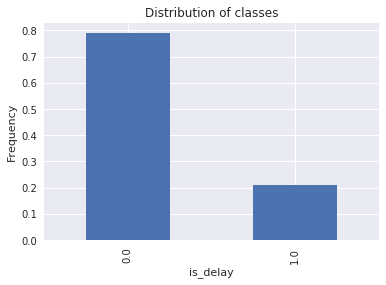

In [25]:
(data.groupby('is_delay').size()/len(data) ).plot(kind='bar')
plt.ylabel('Frequency')
plt.title('Distribution of classes')
plt.show()

**问题**：您能从柱状图中推断出有关延误率和不延误率的什么信息？

**答案**：80% 的航班按时抵达，20% 的航班没有按时抵达。这明显是类不平衡。

**问题**： 

- 哪个月的延误次数最多？
- 一天之中什么时候的延误次数最多？
- 星期几的延误次数最多？
- 哪家航空公司的延误次数最多？
- 哪个出发地和目的地机场的延误次数最多？
- 航程是不是与延误有关的一项因素？

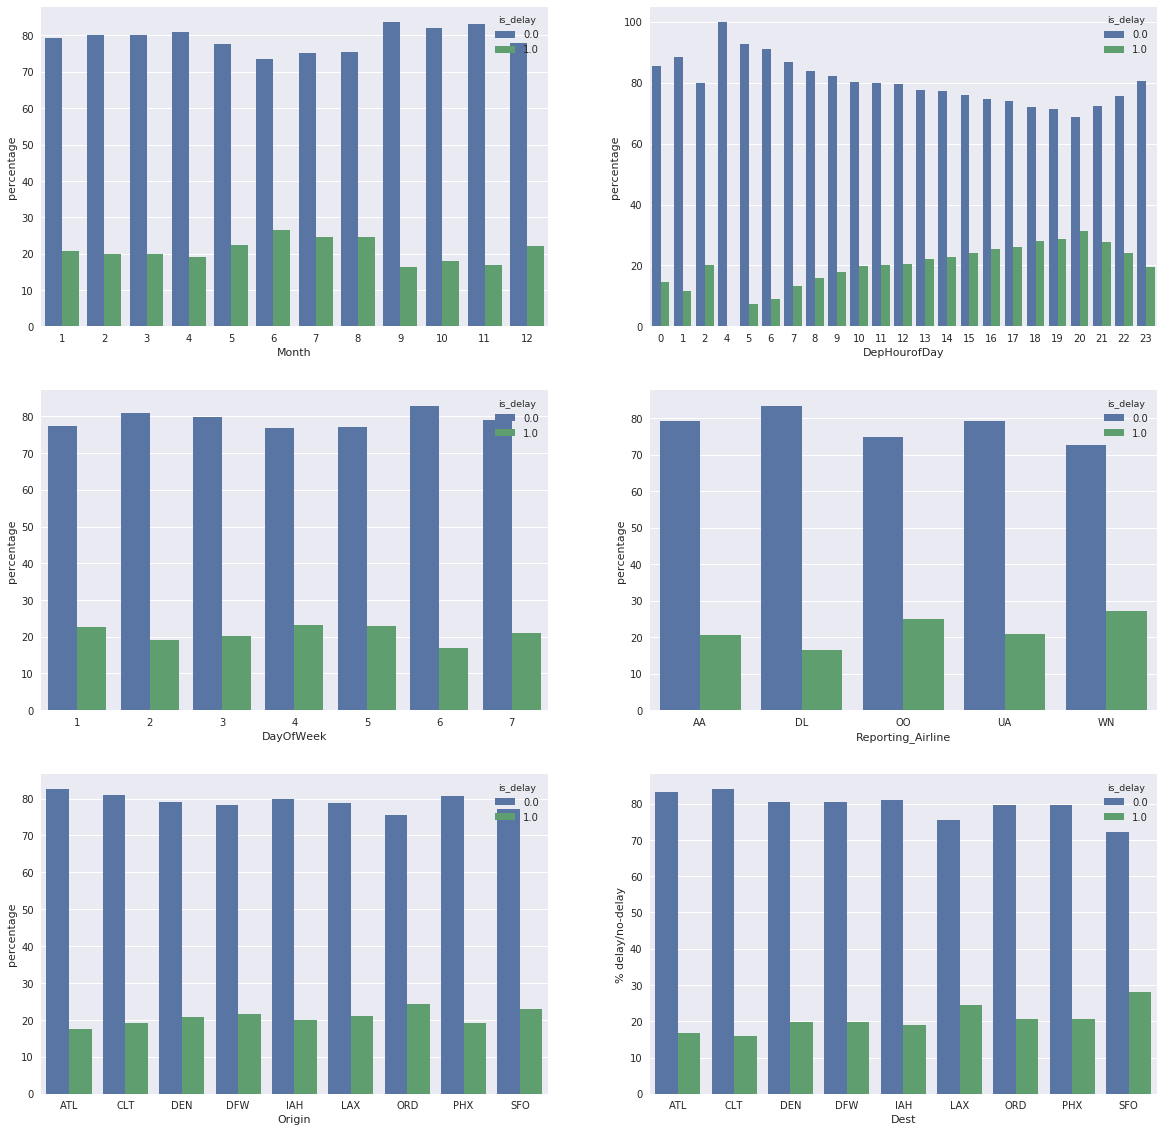

In [26]:
viz_columns = ['Month', 'DepHourofDay', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest']
fig, axes = plt.subplots(3, 2, figsize=(20,20), squeeze=False)
# fig.autofmt_xdate(rotation=90)

for idx, column in enumerate(viz_columns):
    ax = axes[idx//2, idx%2]
    temp = data.groupby(column)['is_delay'].value_counts(normalize=True).rename('percentage').\
    mul(100).reset_index().sort_values(column)
    sns.barplot(x=column, y="percentage", hue="is_delay", data=temp, ax=ax)
    plt.ylabel('% delay/no-delay')
    

plt.show()

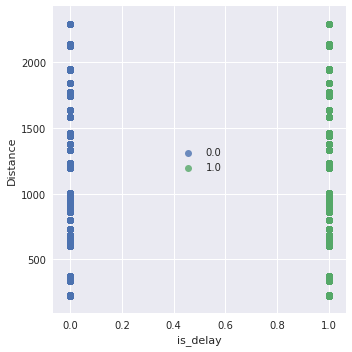

In [27]:
sns.lmplot( x="is_delay", y="Distance", data=data, fit_reg=False, hue='is_delay', legend=False)
plt.legend(loc='center')
plt.xlabel('is_delay')
plt.ylabel('Distance')
plt.show()

**答案**
- 我们看到，五月、六月、七月和八月（5 到 8 月）的延误率较高。
- 一天之中，晚上的延误率比白天高。凌晨 3 点没有航班起飞。
- 一个星期里，星期日 (1)、星期四 (4) 和星期六 (7) 的延误次数相对较多。
- 与其他航空公司相比，WN 航空公司的延误率最高。
- 短途和长途航班看起来都会发生延误。
- 与其他目的地相比，目的地为 SFO 的航班延误次数较多。

尽管某些变量已编码为数字，但一定要将其视为分类变量，因为在这些变量和目标变量之间没有数量关系。

### 特征

查看所有列及其具体类型。

In [28]:
data.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
       'CRSDepTime', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup',
       'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'AirTime', 'DepHourofDay'],
      dtype='object')

筛选出所需的列：
- Date 是多余的数据，因为已经有 Year、Quarter、Month、DayofMonth 和 DayOfWeek 可以描述日期。
- 使用 Origin 和 Dest 代码，而不是 OriginState 和 DestState。
- 因为您只是在对航班是否延误进行分类，所以不需要 TotalDelayMinutes、DepDelayMinutes 和 ArrDelayMinutes。

将 DepHourofDay 视为分类变量，因为它与目标没有数量关系。
- 如果必须对其进行独热编码，则会多出 23 列。
- 处理分类变量的其他方法包括进行哈希编码、进行正则化均值编码以及将值拆分到存储桶中等等。
- 在这里只需拆分到存储桶中即可。

**提示**：要将列类型更改为类别，请使用 `astype` 函数（[文档](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html)）。

In [29]:
data_orig = data.copy()
data = data[[ 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek',
       'Reporting_Airline', 'Origin', 'Dest','Distance','DepHourofDay', 'is_delay']]
categorical_columns = ['Quarter', 'Month', 'DayofMonth', 'DayOfWeek',
       'Reporting_Airline', 'Origin', 'Dest', 'DepHourofDay', 'is_delay']
for c in categorical_columns:
    data[c] = data[c].astype('category')

要使用独热编码，请针对上述选择的分类数据列使用 Pandas 函数 `get_dummies`。然后可以使用 Pandas 函数 `concat` 将生成的这些特征合并到原始数据集中。要对分类变量进行编码，您也可以使用关键字 `drop_first=True` 来进行*虚拟编码*。有关虚拟编码的更多信息，请参阅 https://en.wikiversity.org/wiki/Dummy_variable_(statistics)。

例如：
```
pd.get_dummies(df[['column1','columns2']], drop_first=True)
```

In [30]:
data_dummies = pd.get_dummies(data[categorical_columns], drop_first=True)
data = pd.concat([data, data_dummies], axis = 1)
categorical_columns.remove('is_delay')
data.drop(categorical_columns,axis=1, inplace=True)

确认数据集和新列的长度。

In [31]:
len(data)

1635590

In [32]:
data.columns

Index(['Distance', 'is_delay', 'Quarter_2', 'Quarter_3', 'Quarter_4',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN',

现在可以开始训练模型了。在拆分数据前，请将 `is_delay` 列重命名为 `target`。

**提示**：您可以使用 Pandas 函数 `rename`（[文档](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html)）。

In [33]:
data.rename(columns = {'is_delay':'target'}, inplace=True )